In [21]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
from scipy.interpolate import interp1d

from sklearn.impute import KNNImputer
from tqdm.notebook import tqdm
from scipy.stats import pearsonr
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings('ignore')

import glob
from tqdm.notebook import tqdm
import missingno as msno 


import scienceplots
plt.style.use(['ieee','bright','no-latex'])
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["figure.titleweight"]=25

np.random.seed(18)

In [22]:
def create_nans_continously(data,perc=0.1):
    arr=data.copy()
    arr=arr.astype('float')
    loc=np.random.choice(np.arange(0,len(data)*(1-perc)-1),size=1)[0]
    arr[int(loc):int(loc)+int(len(data)*perc)] = -999
    arr[arr == -999] = np.nan
    return arr


def create_nans_random(data,perc=0.1):
    missing_len=int(len(data)*perc)
    arr=data.copy()
    arr=arr.astype('float')
    for _ in range(missing_len):
            ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            while pd.isnull(arr[ind]):
                ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            arr[ind]=np.nan    
    return arr


def create_nans_selectively(data,perc=0.1):
    """
    data : Enter data in array (numpy array) that needs transformation
    perc : Number b/w 0 to 1 denoting percentage of data to be removed
    """
    arr=data.copy()
    missing_len=int(len(arr)*perc)
    # Consecutively
    for i in range(3):
        temp_miss=int(np.random.choice(np.arange(0.1*missing_len/3,missing_len/3),size=1)[0])
        loc_st=int(np.random.choice(np.arange(len(data)*i//3,len(data)*(i+1)//3-temp_miss),size=1)[0])
        k=0
        while temp_miss!=k and loc_st<len(data):
            if not pd.isnull(arr[loc_st]):
                arr[loc_st]=np.nan
                k+=1
            loc_st+=1
        missing_len-=k
        # Randomly
    for _ in range(missing_len):
            ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            while pd.isnull(arr[ind]):
                ind=np.random.choice(np.arange(0,len(data)-1),size=1)[0]
            arr[ind]=np.nan    
    return arr


def rmse_data(true,pred):
    return np.sqrt(1/len(true)*np.sum(np.square((true-pred))))


def create_nans_selectively_fixed_gap(data,perc=0.1,gap=2):
    """
    data : Enter data in array (numpy array) that needs transformation
    perc : Number b/w 0 to 1 denoting percentage of data to be removed
    """
    arr=data.copy()
    missing_len=int(len(arr)*perc)

    while missing_len>0:
        temp_miss=gap
        loc_st=int(np.random.choice(np.arange(0,len(data)-temp_miss),size=1)[0])
        flag=1
        st=loc_st
        while st<len(data):
            if pd.isnull(arr[st]):
                flag=0
                break
            st+=1

        if flag==1:
            for i in range(loc_st,loc_st+gap+1):
                arr[i]=np.nan
        missing_len-=gap
    return arr

In [23]:
def linear_int(data):
    valid_indices = np.arange(len(data))
    valid_data = ~np.isnan(data)
    interpolated_data = np.interp(valid_indices, valid_indices[valid_data], data[valid_data])
    return list(interpolated_data)

def knn_interpolate(data):
    arr=data.copy()
    time=np.arange(1,len(arr)+1,1)
    df=pd.DataFrame({'time':time,'arr':arr})
    knn=KNNImputer(n_neighbors=10)
    imputed=pd.DataFrame(knn.fit_transform(np.array(df)),columns=df.columns)['arr'].values
    return imputed


def spline_interpolation(arr, degree):
    x=arr.copy()
    nan_indices = np.isnan(x)
    non_nan_indices = np.arange(len(x))[~nan_indices]
    non_nan_values = arr[~nan_indices]

    if degree==1:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='slinear', fill_value='extrapolate')
    elif degree==2:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='quadratic', fill_value='extrapolate')
    elif degree==3:
        interpolator = interp1d(non_nan_indices, non_nan_values, kind='cubic', fill_value='extrapolate')
    
    interpolated_values = interpolator(np.arange(len(x)))

    return interpolated_values

## Choose DataFrame

In [24]:
# def score_data(path):
#     # Calculates Fill Ratio
#     df_out=pd.DataFrame()
#     site_ids=[]
#     station_name=[]
#     for file in tqdm(glob.glob(path+'/*.csv')):
#         df=pd.read_csv(file)
#         site_ids.append(df['siteId'].unique()[0])
#         station_name.append(df['siteName'].unique()[0])
#         df=df[['from date','PM2.5','PM10','SO2',"NO2",'CO','Ozone','NH3']]
#         df_out = pd.concat([df_out, pd.DataFrame((len(df)-df.isna().sum())/len(df)).T], ignore_index=True)
#     df_out.insert(0,'siteId',site_ids)
#     df_out.insert(0,'siteName',station_name)
#     return df_out


# path_data="D:\\BTP\\Data\\site_data_processed" # Path to folder containing all csv's
# df_fill_ratio=score_data(path_data)
# temp=df_fill_ratio[['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']].mean(axis=1)
# df_fill_ratio['mean_fill_ratio']=temp
# df_fill_ratio.to_excel('fill_ratio.xlsx',index=False)

In [25]:
df_fill_ratio=pd.read_excel('fill_ratio.xlsx')
df_fill_ratio.sort_values('mean_fill_ratio',ascending=False).reset_index(drop=True).head(10)

,siteName,siteId,from date,PM2.5,PM10,SO2,NO2,CO,Ozone,NH3,mean_fill_ratio
0,"Major Dhyan Chand National Stadium, Delhi - DPCC",site_1425,1,0.972038,0.965399,0.913561,0.949263,0.878453,0.929115,0.930040,0.943236
1,"Padmapukur, Howrah - WBPCB",site_1416,1,0.924486,0.916495,0.953470,0.944012,0.962055,0.957922,0.938544,0.939155
2,"Model Town, Patiala - PPCB",site_1437,1,0.958282,0.954081,0.899041,0.927608,0.924788,0.963031,0.929166,0.938535
3,"Kalal Majra, Khanna - PPCB",site_1450,1,0.942774,0.938784,0.893470,0.950171,0.787436,0.949806,0.951535,0.937756
4,"Sri Aurobindo Marg, Delhi - DPCC",site_1562,1,0.968419,0.964549,0.885125,0.950279,0.888938,0.922214,0.933510,0.937349
5,"Dr. Karni Singh Shooting Range, Delhi - DPCC",site_1421,1,0.942876,0.973230,0.923909,0.939241,0.906546,0.912711,0.923732,0.935950
6,"Bhopal Chauraha, Dewas - MPPCB",site_1404,1,0.935496,0.952443,0.912796,0.932425,0.930216,0.940348,0.931506,0.934169
7,"Victoria, Kolkata - WBPCB",site_309,1,0.932968,0.927739,0.952517,0.925742,0.954543,0.946980,0.912397,0.933057
8,"Okhla Phase-2, Delhi - DPCC",site_1428,1,0.972095,0.963270,0.909126,0.945114,0.899965,0.912614,0.893584,0.932634
9,"Dwarka-Sector 8, Delhi - DPCC",site_1422,1,0.966324,0.954047,0.868749,0.943276,0.892100,0.929720,0.924223,0.931056


## Interpolation

In [26]:
path_data="D:\\BTP\\Data\\site_data_processed"
df=pd.read_csv(f'{path_data}/site_{309}.csv')
station_name=df['siteName'].unique()[0]
print('Station Name:',station_name)
df['from date']=pd.to_datetime(df['from date'])
df=df[['from date','PM2.5','PM10','SO2',"NO2",'Ozone','NH3']]
print('Converting 15min resolution data to Hourly Data...')
df = df.resample('H', on='from date').mean().reset_index()
msno.matrix(df)
df=df.dropna().reset_index(drop=True)
print('NaNs Dropped')
df.head()

Station Name: Victoria, Kolkata - WBPCB
Converting 15min resolution data to Hourly Data...
NaNs Dropped


,from date,PM2.5,PM10,SO2,NO2,Ozone,NH3
0,2018-09-13 12:00:00,54.8750,76.3700,14.2550,17.9725,71.4250,7.3750
1,2018-09-13 13:00:00,55.2675,90.0000,17.0600,20.3075,75.0700,7.6050
2,2018-09-13 14:00:00,54.9200,96.8175,15.4000,22.4275,71.9825,7.4775
3,2018-09-13 15:00:00,52.8925,93.7050,14.7475,27.4250,69.4100,6.9800
4,2018-09-13 16:00:00,55.9275,87.3625,14.5175,29.7025,63.6125,7.0750


<Axes: >

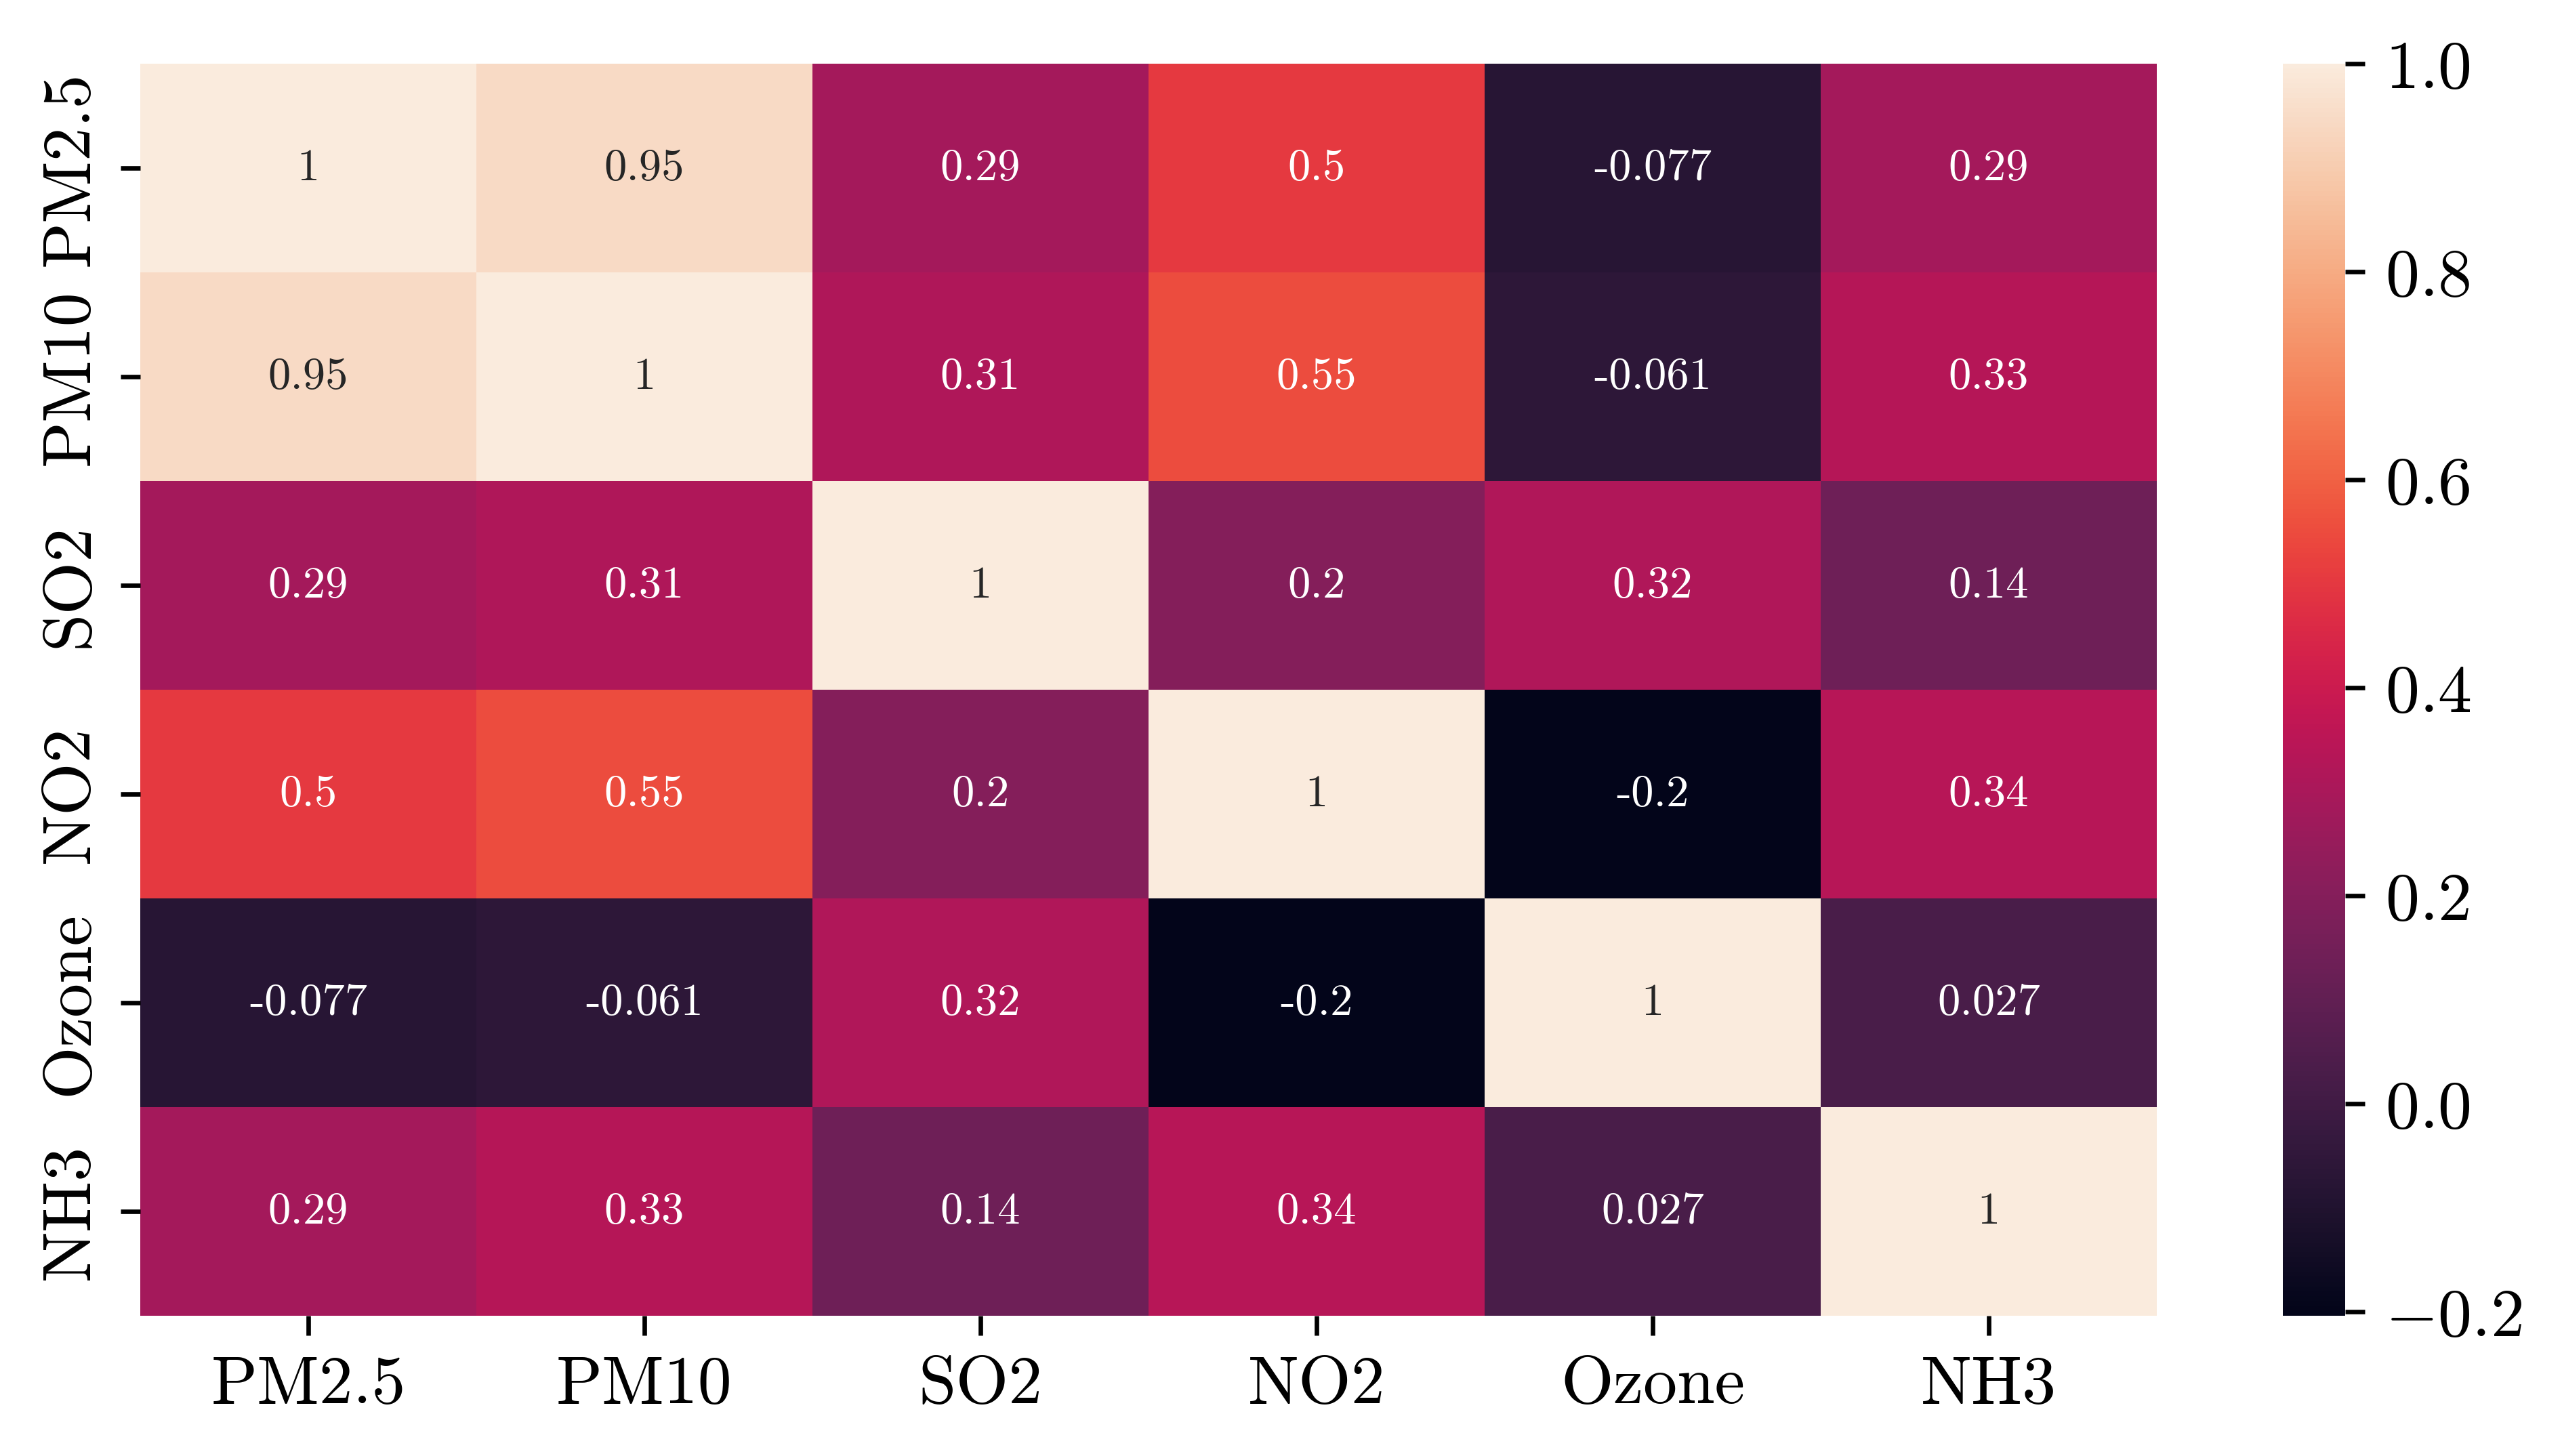

In [27]:
sns.heatmap(df[['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']].corr(),annot=True)

In [28]:
df_nan=df.copy()
cols=['PM2.5','PM10','SO2',"NO2",'Ozone','NH3']
for col in cols:
    df_nan[col]=create_nans_selectively(df_nan[col],perc=0.2)

In [29]:
df_mice=df_nan.copy()
missing_mask=df_mice.isna()

In [30]:
imputer = IterativeImputer(max_iter=500, random_state=0, min_value=0, max_value=1000,tol=1e-8)
imputed_values=imputer.fit_transform(df_mice[cols])
df_mice[cols]=imputed_values
imputer.n_iter_

205

In [31]:
# Linear Interpolation
df_linear=df_nan.copy()
df_knn=df_nan.copy()
#df_spline=df_nan.copy()
for col in cols:
    df_linear[col]=linear_int(df_linear[col])
    df_knn[col]=knn_interpolate(df_knn[col])
    #df_spline[col]=spline_interpolation(df_spline[col],2)

In [34]:
df_interpolation=pd.DataFrame()
#interpolation=['KNN','Linear','MICE','Spline']
interpolation=['KNN','Linear','MICE']
df_interpolation=pd.concat([df_interpolation, pd.DataFrame(np.abs((df[cols]-df_knn[cols])).mean()).T], ignore_index=True)
df_interpolation=pd.concat([df_interpolation, pd.DataFrame(np.abs((df[cols]-df_linear[cols])).mean()).T], ignore_index=True)
df_interpolation=pd.concat([df_interpolation, pd.DataFrame(np.abs((df[cols]-df_mice[cols])).mean()).T], ignore_index=True)
#df_interpolation=pd.concat([df_interpolation, pd.DataFrame(np.abs((df[cols]-df_spline[cols])).mean()).T], ignore_index=True)
df_interpolation['interpolation']=interpolation
df_interpolation

,PM2.5,PM10,SO2,NO2,Ozone,NH3,interpolation
0,3.437265,8.547075,0.892110,3.411602,3.286381,1.179547,KNN
1,2.072089,5.838369,0.708980,4.481128,1.550138,1.255161,Linear
2,3.029891,3.783466,1.071306,4.457173,4.422792,3.230909,MICE


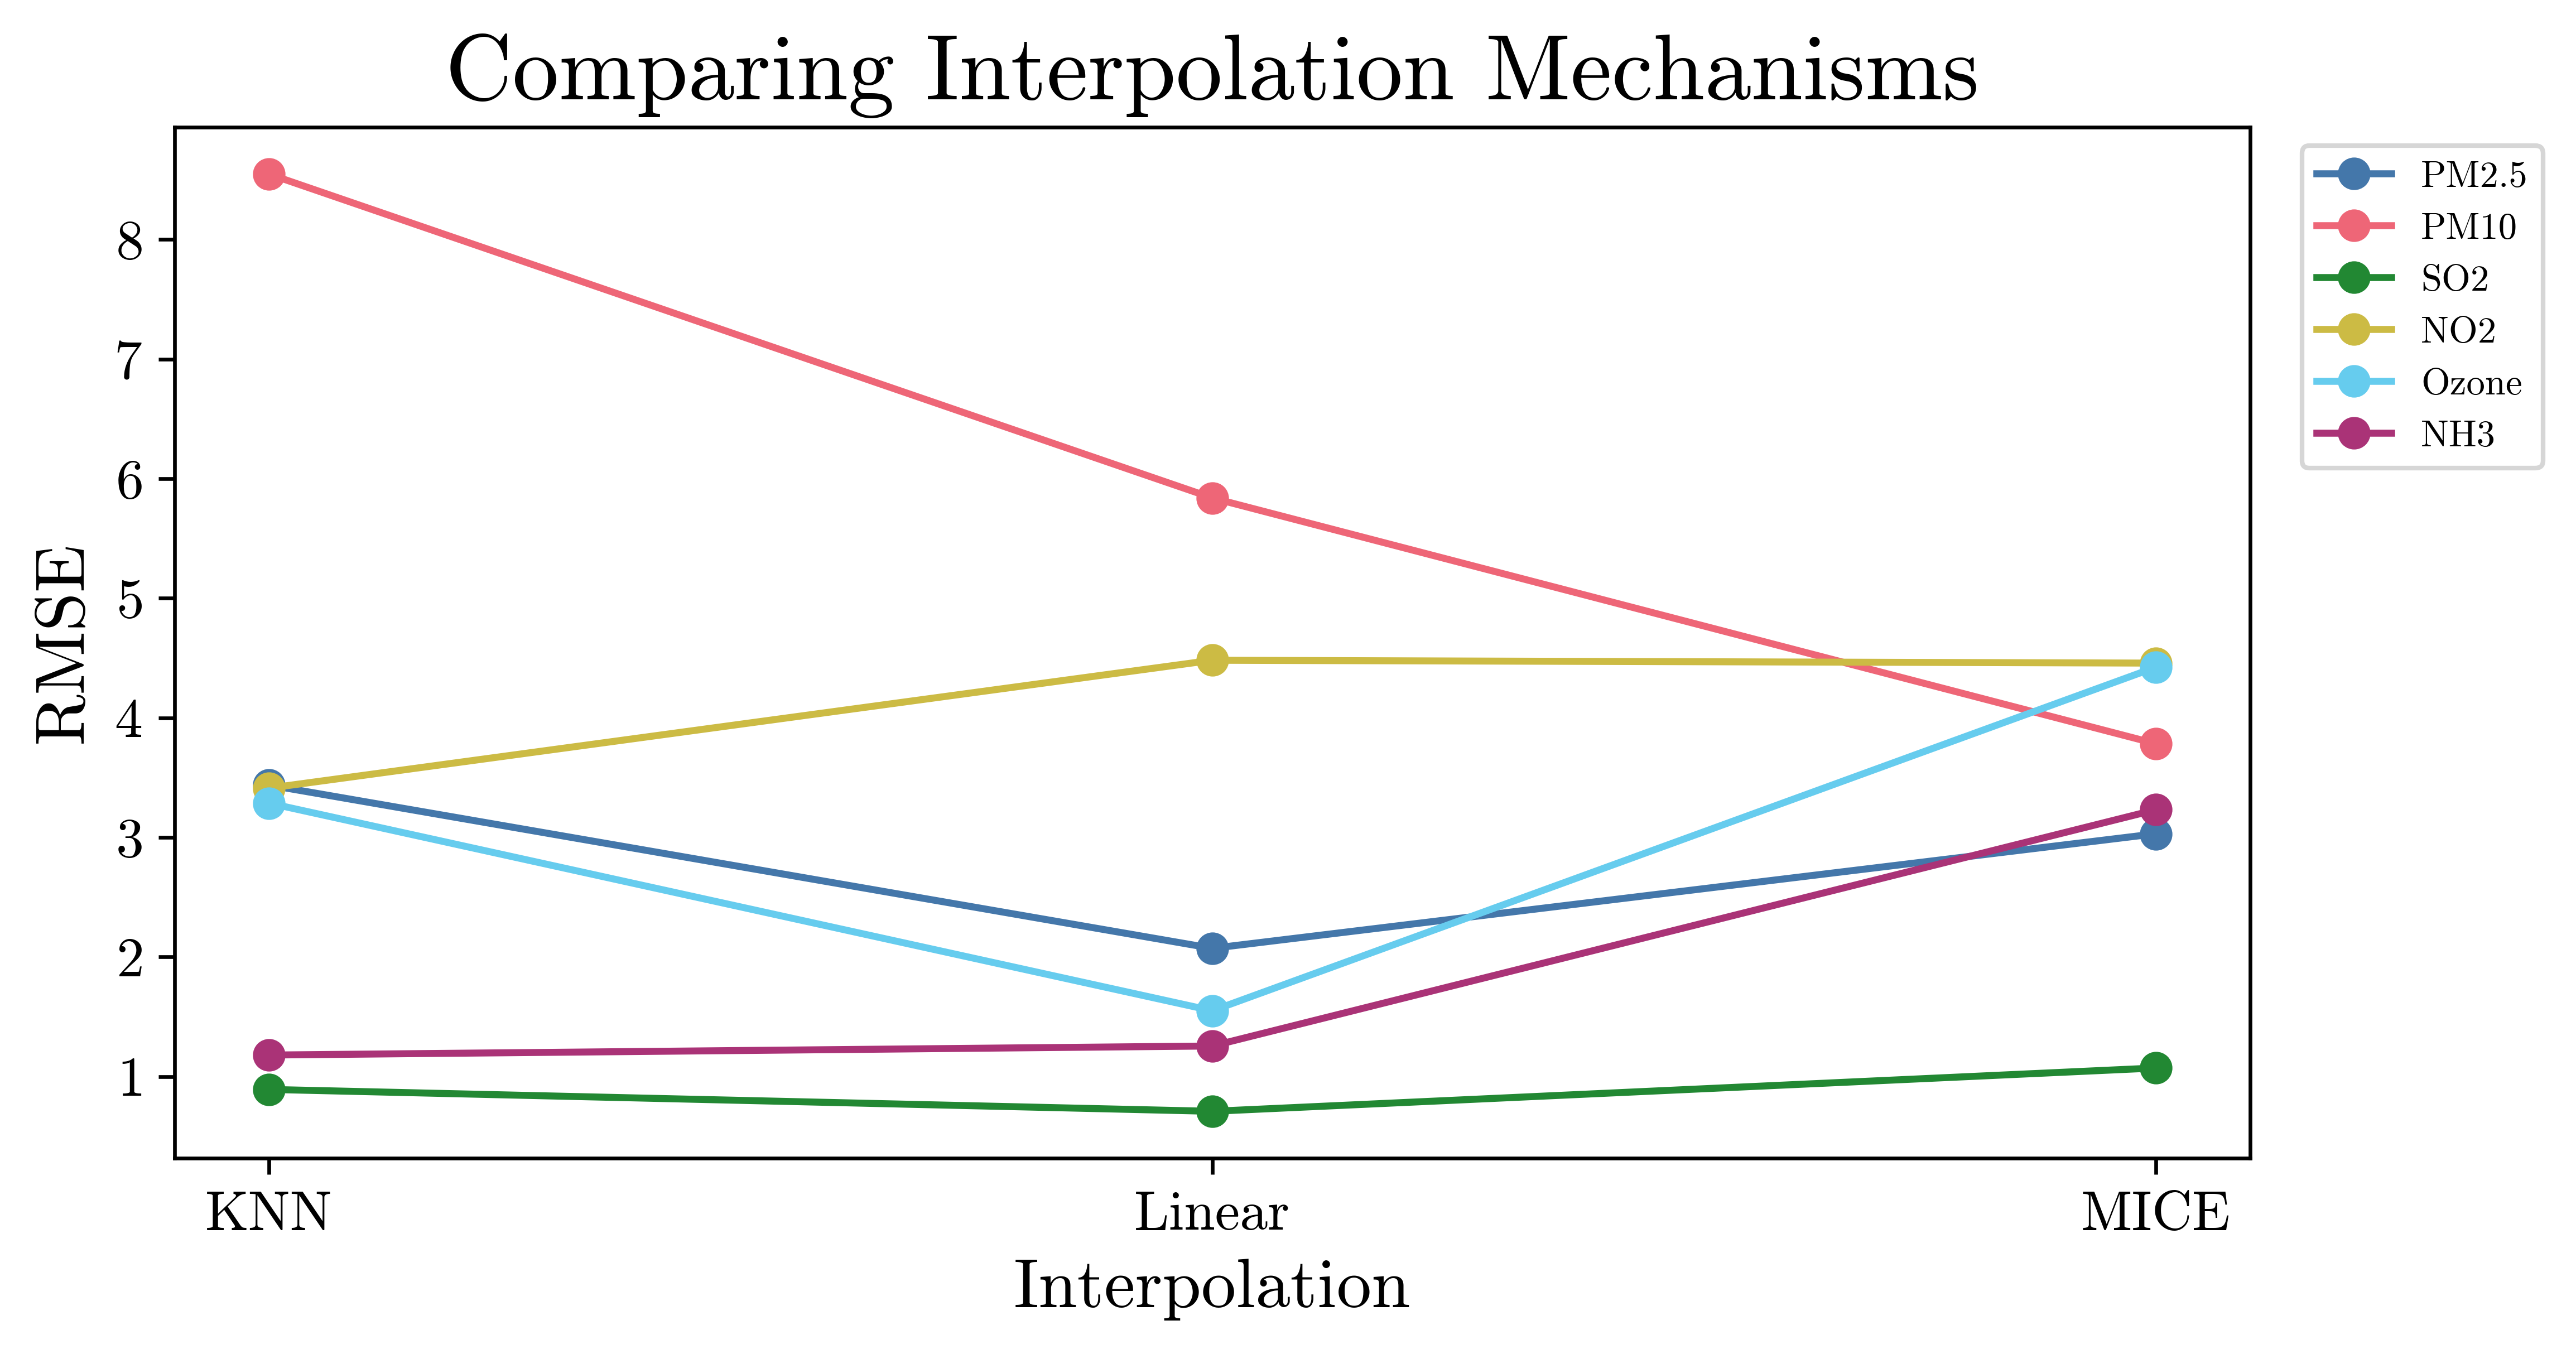

In [35]:
for col in cols:
    plt.plot(df_interpolation['interpolation'],df_interpolation[col],'-o',label=col)

plt.xlabel('Interpolation')
plt.ylabel('RMSE')
plt.title('Comparing Interpolation Mechanisms')
plt.legend(bbox_to_anchor=(1.15, 1))